Autogen version: 0.5.7
Max SP TFLOP/s with FMA 25.068
Max DP TFLOP/s with FMA 0.392
Max SP TFLOP/s w/out FMA 12.534
Max DP TFLOP/s w/out FMA 0.196
Max TINTOP/s 12.534
SP Balance Point is at: 32.97 flop/byte
DP Balance Point is at: 0.52 flop/byte
INT Balance Point is at: 16.49 intop/byte

These values get passed as LLM context so the model can infer about rooflines:
Peak SP GFLOP/s 25067.52 with FMA
Peak DP GFLOP/s 391.68 with FMA
Peak GINTOP/s 12533.76 with FMA
scraped and pruned CUDA programs count 297
scraped and pruned OMP  programs count 242


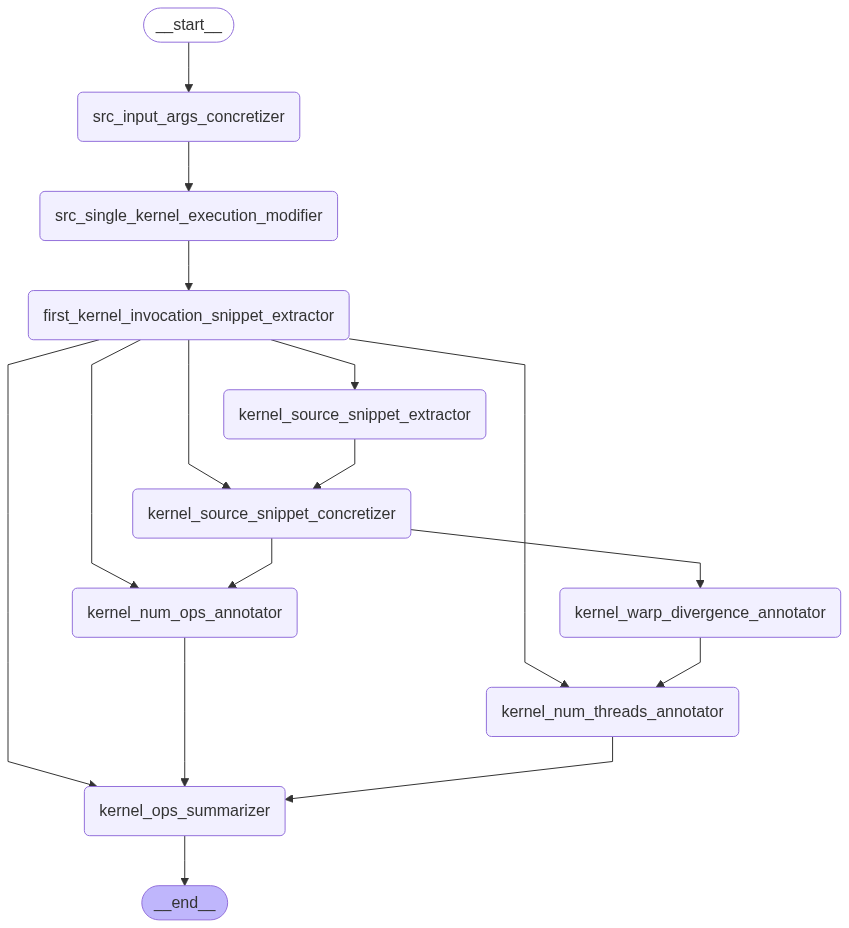

In [1]:
from roofline_utils import *
from langchain.globals import set_verbose
set_verbose(True)

from langgraph_cuda_static_analysis_complex import *

import re
from collections import Counter

import time
import argparse
import sys
import os

In [2]:
# ### Open the Trin/Val Data CSV Files
dtypes['language'] = 'string'
dtypes['numTokens'] = np.int64
dtypes['kernelCode'] = 'string'
dtypes['kernelSASS'] = 'string'
dtypes['isBB'] = np.int64
dtypes['class'] = 'string'
dtypes['answer'] = 'string'

reasoning_models = ['o3', 'o1', 'o4']

def is_reasoning_model(modelName):
    # the last part of the model name is the model name
    # example: openai/o3-mini-2024-11-20 is o3-mini-2024-11-20
    mName = modelName.split('/')[-1]
    for m in reasoning_models:
        if m in mName:
            return True
    return False

In [3]:

trainDF = pd.read_csv('train-dataset-balanced.csv', quotechar='"', dtype=dtypes)
valDF = pd.read_csv('validation-dataset-balanced.csv', quotechar='"', dtype=dtypes)

trainDF['isTrain'] = 1
valDF['isTrain'] = 0

df = pd.concat([trainDF, valDF], ignore_index=True)

# keep only the CUDA codes
df = df[df['language'] == 'CUDA']

print(df.shape)

(170, 24)


In [4]:
# Calculate the total number of threads from the gridSz and the blockSz
# grid size is a string of format "(x, y, z)"
# block size is a string of format "(x, y, z)"
def calc_total_threads(gridSz:str, blockSz:str):
    gridSz = eval(gridSz)
    blockSz = eval(blockSz)
    total_threads = gridSz[0] * gridSz[1] * gridSz[2] * blockSz[0] * blockSz[1] * blockSz[2]
    return str(total_threads)

In [5]:
for index, row in df.iterrows():

    query_data: KernelAnalysisState = {
        "source_code": row['kernelCode'],
        "kernel_name": row['Kernel Name'],
        "exec_args": row['exeArgs'],
        "grid_size": row['Grid Size'],
        "block_size": row['Block Size'],
        "total_num_threads": calc_total_threads(row['Grid Size'], row['Block Size']),
    }


    result = graph.invoke(query_data)
    print(result['summarized_kernel_ops'])

    # perf had been scaled to terra-ops when pre-processing the data, need to scale to just ops
    #INTPerf: {row['intops'] / (1e-9 * row['xtime'])}
    #INTPerf: {row['intPerf']*1e12}
    #INTOPs: {row['intPerf']*(1e3 * row['xtime'])}
    print(f"""Expected (Empirical Ground-Truth) OPs Values:
    INTOP: {row['intops']}
    SP-FLOP: {row['spPerf']*(1e3*row['xtime'])}]
    DP-FLOP: {row['dpPerf']*(1e3*row['xtime'])}]
          """)
    break






---------- BEGIN STEP 1: Source Code Concretization ----------

```cpp
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <chrono>
#include <cuda.h>

template <class T, std::size_t CHANNELS_PER_ITER>
__global__
void resize (
    T *__restrict__ output,
    size_t output_size, int out_height, int out_width,
    const T *__restrict__ input, int in_height, int in_width,
    float o2i_fy, float o2i_fx, bool round, bool half_pixel_centers)
{
    auto in_image_size = 1080 * 1920;
    auto out_image_size = 256 * 256;

    auto num_effective_channels = output_size / out_image_size;

    auto num_channel_iters_per_xy = (num_effective_channels / CHANNELS_PER_ITER);

    auto iters_required = num_channel_iters_per_xy * out_image_size;

    for (int iter = blockIdx.x * blockDim.x + threadIdx.x;
             iter < iters_required; iter += blockDim.x * gridDim.x) {

        const int c_start = (iter / out_image_size) * CHANNELS_PER_ITER;

        const int y = (iter % out_image_si

KeyError: "Input to ChatPromptTemplate is missing variables {'...'}.  Expected: ['...', 'snippet_kernel_src_concretized_values'] Received: ['snippet_kernel_src_concretized_values']\nNote: if you intended {...} to be part of the string and not a variable, please escape it with double curly braces like: '{{...}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "